# Tutorial 4 - Word Embeddings

In the lectures, so far you have covered NLP processing of textual data and word embeddings. Therefore, in today's notebook we will revisit the algorithm Word2Vec (W2V) that you can use to learn word embeddings with two models, i.e., CBOW and Skip-Gram. While the two flavours of W2V differ in how they are modeling token embeddings, both models aim at producing dense numerical vector representations, that capture the semantic relationships in the input textual samples. Once we have covered how to create pretrained embedding dictionaries compatible with keras, we will generate two-dimensional representation of the trained word embeddings that is suitable for plotting purposes. Afterward, we will use the embeddings from W2V in an MLP-based network trained for sentiment classification. <br>

Here is the outline of today's notebook:
*   Word2Vec: Implementation of an Embedding Layer Dictionary with CBOW and Skip-Gram (Demo). 
*   Plotting Embeddings using t-SNE (Exercise 1).
*   MLP-based Neural Network with W2V Embeddings for Sentiment Classification (Exercise 2).


In [47]:
# required packages
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from bs4 import BeautifulSoup
import re
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import recall_score,precision_score,roc_auc_score
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import TextVectorization
from gensim.models import Word2Vec 
import time
import keras
from keras import Sequential
import seaborn as sns
import matplotlib.pyplot as plt

## **1. Word2Vec: Implementation of an Embedding Layer Dictionary with CBOW and Skip-Gram** (Demo)<br>

We use W2V to train word embeddings, which capture the contextual meaning of individual tokens:<br>
<img src="https://github.com/Humboldt-WI/demopy/raw/main/W2V.PNG" width="1140" height="610" alt="W2V">

In W2V, each word is represented by two vectors of dimension *𝑑*, as words take both roles, i.e., context and target word. The word vectors are the parameters of the neural network, which we train on our corpus of textual data for language modeling purposes. The goal is to learn low-dimensional, dense representation of words as numerical continuous vectors, which enable ML models to understand the meaning and the semantics of words algorithmically. Therefore, language modeling can be regarded as the upstream task, whereas, e.g., sentiment classification using the pretrained embeddings from W2V would be the downstream task. There are two variants of W2V, which we can use to obtain word embeddings: <br>

<img src="https://github.com/Humboldt-WI/demopy/raw/main/CBOW_and_SkipGram.PNG" width="1450" height="390" alt="CBOW_and_SkipGram">

The Continuous Bad of Word (CBOW) model differs from the Skip-Gram model mainly in that the former predicts the center word from surrounding context tokens, whereas the latter predicts the context from the center word. The surrounding words are quantified by defining a context window. In the above visualization, the context window is set to 2 tokens. The training process involves parsing the textual samples with context size 2, and sliding the training tuples consisting of inputs and targets until the end of the sentences. Language modeling does not necessitate target labels or text annotation, as the training inputs and outputs are obtained from parsing the textual samples. Thus, we call such training process self-supervised. W2V in its two flavours is trained with a shallow neural network. For simplicity purposes, assume you have a single token as the input and the following word as the target:<br>
<img src="https://github.com/Humboldt-WI/demopy/raw/main/W2V_Shallow_Network_Example.PNG" width="1450" height="410" alt="W2V_Shallow_Network_Example">

The input layer of the network represents a one-hot-vector, which has a positive value at the index of the input word. The dot product of the one-hot-vector with the continuous trainable weights of the shallow network amounts to indexing the vector of weights in the hidden layer associated with the input word *can*. This is also the vector of weights that we will use as our word embeddings in the downstream task. If we choose to train our own embeddings using W2V instead of downloading pretrained embeddings, then, first, we would have to clean our dataset. Thus, let's import the IMDB dataset, and clean it using our `NLP_preprocessing_pipeline` function from the previous tutorial notebook. While previously the function returned a list of cleaned tokens, in this notebook we will design our function to return the whole cleaned string of the textual samples, as we will later feed these cleaned strings to a `TextVectorization` layer from `keras`:<br>

In [48]:
# Lemmatize with POS Tag (Parts of Speech tagging)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def get_wordnet_pos(word:str)->str:
    """Map POS tag to first character for lemmatization

    Returns:
    --------
    pos: str
        The positional tag of speech retrieved from wordnet database.
    """

    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
                
    pos=tag_dict.get(tag,wordnet.NOUN)

    return pos

def NLP_preprocessing_pipeline(textual_sample:str)->list:
    '''
    Implements 7 steps of an NLP preprocessing pipeline.

    Parameters:
    -----------
    textual_sample:str
        The input text that requires preprocessing

    Returns:
    --------
    preprocessed_textual_sample:str
        The textual sample after each of the 7 preprocessing steps have been applied.

    '''
    lemmatizer = WordNetLemmatizer()

    #Removing of URLs:
    preprocessed_textual_sample = re.sub("http\S+", "",textual_sample)

    #Removing of HMTL tags:
    preprocessed_textual_sample = BeautifulSoup(preprocessed_textual_sample).get_text()

    #Removing of non-alphabetic characters:
    preprocessed_textual_sample = re.sub("[^a-zA-Z]", " ",preprocessed_textual_sample)

    #Changing all tokens to lower case:
    preprocessed_textual_sample = preprocessed_textual_sample.lower()

    #Tokenization:
    preprocessed_textual_sample=nltk.word_tokenize(preprocessed_textual_sample)

    #Stopwords removal:
    preprocessed_textual_sample = [w for w in preprocessed_textual_sample if w not in stopwords.words("english")]

    #Lemmatization:
    preprocessed_textual_sample=[lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in preprocessed_textual_sample]
    preprocessed_textual_sample=' '.join(preprocessed_textual_sample)
    
    return preprocessed_textual_sample

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/RDC/velegeor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/RDC/velegeor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/RDC/velegeor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/RDC/velegeor/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [49]:
df = pd.read_csv("IMDB-50K-Movie-Review.zip", sep=",", encoding="ISO-8859-1").iloc[:5000,:]
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [ ]:
X=df['review'].apply(NLP_preprocessing_pipeline)

In [ ]:
#We will save the cleaned version of our movie reviews as the preprocessing takes a while to complete.
with open('cleaned_X_str.pkl','wb') as f:
    pickle.dump(X,f)

In [ ]:
with open('cleaned_X_str.pkl','rb') as f:
    X=pickle.load(f)

In [ ]:
X[:10]

0    one reviewer mention watch oz episode hooked r...
1    wonderful little production film technique una...
2    thought wonderful way spend time hot summer we...
3    basically family little boy jake think zombie ...
4    petter mattei love time money visually stun fi...
5    probably time favorite movie story selflessnes...
6    sure would like see resurrection date seahunt ...
7    show amaze fresh innovative idea first air fir...
8    encourage positive comment film look forward w...
9    like original gut wrench laughter like movie y...
Name: review, dtype: object

Next, we will build our vocabulary with the `TextVectorization` layer. The latter transforms the input strings to a list of integer token indices, which are associated with a unique word in our vocabulary. We learn the vocabulary by calling the function `adapt`. When the layer is adapted, it learns the frequency of the individual tokens in the dataset. If we specify a maximum size of our vocabulary, e.g., 15k, then the layer would create a vocabulary containing the 15k most frequently encountered words in the cleaned textual samples. Words outside of this vocabulary get mapped to the UNK-token, i.e., out-of-vocabulary token. For consistency purposes, we will also specify the maximal sequence length for each textual sample. For instance, if we set the sequence length to a maximum of 100 tokens, then textual samples with less tokens will get padded with zeros to a length of 100. Similarly to other preprocessing techniques that we have applied so far in this semester, the layer `TextVectorization` is adapted on the train set only. For this reason, we will split our cleaned data *X* into train and test set before the learning of the vocabulary takes place. 

In [ ]:
#Split into train and test subsets:
y=df['sentiment'].map({'positive':1,'negative':0}).values  # map text-based class labels to numbers
Xclean_train, Xclean_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5)  # data partitioning

# Create a vectorization layer
vocab_size = 15000
seq_length = 100
vectorize_layer = TextVectorization(
    standardize = None,
    #since we have cleaned our data already, 
    # we pass None to the text standardization parameter.
    max_tokens = vocab_size,
    output_sequence_length = seq_length)

#Learn the vocabulary on the train set:
vectorize_layer.adapt(Xclean_train)

#print the first 15 tokens in the vocabulary:
vocab = vectorize_layer.get_vocabulary()
print(vocab[:15])

['', '[UNK]', 'movie', 'film', 'one', 'make', 'like', 'see', 'get', 'well', 'time', 'good', 'watch', 'bad', 'go']


The output from the vectorization layer is a list of integers indicating the position of the words in the vocabulary with the most frequent tokens. Let's take the first clean sample in our test set, and transform it using the `TextVectorization` layer that we have already adapted on our training data:

In [ ]:
print('The first clean textual sample in the test dataset:')
print(Xclean_test.iloc[0],'\n')
print('The corresponding sentiment label: ',y_test[0])

The first clean textual sample in the test dataset:
film try many thing sting political satire hollywood blockbuster sappy romantic comedy family value promo list go fail miserably enough interest keep turn end although appreciate spirit behind war inc depresses see clumsy effort especially take target reflect lack existence serious critique rather simply poor write direction production particular film critique make corporatization war poke fun way diminishes true atrocity happen reminds bit three king similarly trivializes genuine cause concern 

The corresponding sentiment label:  0


In [ ]:
print('The output from the Text Vectorization: ')
vectorize_layer(Xclean_test.iloc[0])

The output from the Text Vectorization: 


<tf.Tensor: shape=(100,), dtype=int64, numpy=
array([    3,    52,    46,    38,  5468,   962,  1776,   251,  2229,
        3511,   609,    99,   115,   479, 11084,   558,    14,   554,
        2910,   101,    80,   172,    92,    26,   161,   722,   824,
         410,   173, 14937,     1,     7,  2860,   516,   176,    33,
        1297,  2044,   228,  2008,   447,  5744,   154,   210,   231,
          85,   334,   214,   732,     3,  5744,     5,     1,   173,
        3243,   171,    30,  8595,   193,  3796,   195,  1279,   114,
         177,   509,  3842,     1,  1508,   472,  1328,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])>

The zeros correspond to an empty token resulting from the padding process, and the index 1 corresponds to the UNK token. Since we are interested in training our own embeddings with W2V, we will first vectorize our train textual samples. We will then use the output to retrieve the corresponding words in string format from our vocabulary, which would serve as the input to W2V. In this way, we would generate embeddings only for the 15k most frequent tokens in our vocabulary. If we feed the cleaned textual samples to W2V without the text vectorization step, then W2V might produce embeddings also for tokens that get mapped to the UNK token during the training process. 

In [ ]:
X_train_vec=vectorize_layer(Xclean_train)
X_train_words = [[vocab[w] for w in rev if vocab[w] not in ['','[UNK]']] for rev in X_train_vec]
#we collect all train words except '' and '[UNK]', as we do not have to learn embeddings for these two tokens.
#When we create our keras embedding layer, we will overwrite all embeddings with those learned with W2V except the embeddings
# for the first two tokens. The embeddings of the latter will be randomly initialized, as the tokens '' and '[UNK]' do not have 
# a specific contextual meaning.  

In [ ]:
#Since this can take a while, we will save result so that we can import it later:
with open('X_train_words.pkl','wb') as f:
    pickle.dump(X_train_words,f)

In [ ]:
with open('X_train_words.pkl','rb') as f:
    X_train_words=pickle.load(f)

Next, we will learn the word embeddings using both CBOW and Skip-Gram. Afterward, we will create embedding layers, the continuous vectors of which will be overwritten with the embeddings from W2V:

In [ ]:
# Train CBOW and SkipGram:
#Keep track of the training time:
embeddings_dimension=300
start_time_cbow=time.time()
w2v_model_cbow = Word2Vec(X_train_words, min_count=100, #we set the minimal token frequency to 100 to avoid creating embeddings for 
                        #rarely represented words
                        window=10, #the size of context
                        epochs=50,  
                        vector_size=embeddings_dimension, #size of embedding
                        workers=4,#for parallel computing
                        sg  = 0)  
end_time_cbow=time.time()

start_time_skipgram=time.time()
w2v_model_skipgram = Word2Vec(X_train_words, min_count=100, window=10,     
                 epochs=50,  vector_size=embeddings_dimension, workers=4, sg  = 1)  

end_time_skipgram=time.time()
print('Training Time with CBOW in Seconds: ',round(end_time_cbow-start_time_cbow,5))
print('Training Time with SkipGram in Seconds: ',round(end_time_skipgram-start_time_skipgram,5))  


#Create corresponding Embedding Layers:
embedding_layer_cbow=keras.layers.Embedding(vocab_size,embeddings_dimension)
embedding_layer_cbow.build(input_shape=(embeddings_dimension))

embedding_layer_skipgram= keras.layers.Embedding(vocab_size,embeddings_dimension)
embedding_layer_skipgram.build(input_shape=(embeddings_dimension))



Training Time with CBOW in Seconds:  6.61499
Training Time with SkipGram in Seconds:  35.39017


In [ ]:
#Alternatively to training your own embeddings, you can download pretrained embeddings using the package gensim:
#import gensim.downloader
#w2v_model_cbow=gensim.downloader.load('word2vec-google-news-300')

In [ ]:
#Overwrite the weights in the embedding layers with the continuous  token representation learned with CBOW and Skip-Gram:
 
embeddings_cbow=[]
embeddings_skipgram=[]

#Fill in the embedding matrices:
for token_idx in range(0,len(vocab)):
    if token_idx>1:
        if vocab[token_idx] in w2v_model_cbow.wv:
            embeddings_cbow.append(w2v_model_cbow.wv[vocab[token_idx]])
        else:#take embedding corresponding to UNK token:
            embeddings_cbow.append(embedding_layer_cbow.get_weights()[0][1])

        
        if vocab[token_idx] in w2v_model_skipgram.wv:
            embeddings_skipgram.append(w2v_model_skipgram.wv[vocab[token_idx]])
        else:#take embedding corresponding to UNK token:
            embeddings_skipgram.append(embedding_layer_skipgram.get_weights()[0][1])

    else:#then take mebeddings of ''-token or '[UNK]'-token:
        embeddings_cbow.append(embedding_layer_cbow.get_weights()[0][token_idx])
        embeddings_skipgram.append(embedding_layer_skipgram.get_weights()[0][token_idx])

#Overwrite the weights in the embedding layers with the corresponding W2V token embeddings.
#You will need the embedding_layer_cbow and embedding_layer_skipgram for the 1. exercise.
embedding_layer_cbow.set_weights(np.array([embeddings_cbow]))
embedding_layer_skipgram.set_weights(np.array([embeddings_skipgram]))

In [140]:
embedding_layer_cbow.set_weights(np.array([embeddings_cbow]))
embedding_layer_skipgram.set_weights(np.array([embeddings_skipgram]))

In [ ]:
with open('embeddings_cbow.pkl','wb') as f:
    pickle.dump(embeddings_cbow,f)

with open('embeddings_skipgram.pkl','wb') as f:
    pickle.dump(embeddings_skipgram,f)

In [ ]:
with open('embeddings_cbow.pkl','rb') as f:
    embeddings_cbow=pickle.load(f)

with open('embeddings_skipgram.pkl','rb') as f:
    embeddings_skipgram=pickle.load(f)

**Demo Summary**:<br>
- we can use W2V to train our own embeddings with two models, i.e., CBOW and Skip-Gram.<br>
- the inputs to W2V are the cleaned tokenized textual samples coming from the vocabulary built with the text vectorization layer. The latter creates the vocabulary from the set of most frequently encountered words in our cleaned dataset.
- once we have trained our embeddings, we save each continuous vector corresponding to a token in our vocabulary in embedding matrices that we use to overwrite the weights of the embedding layers in `keras`. These embedding layers serve as a dictionary to look up words based on their indices produced from the text vectorization transformation.
- we can use these embedding layers when implementing neural networks in `keras` to process text algorithmically. Also, we can use the output of the embedding layers as inputs to dimensionality reduction techniques that produce low dimensional vectors for plotting purposes.

## **2. Plotting Embeddings using t-SNE** (Exercise 1)<br>
T-distributed Stochastic Neighbor Embedding (t-SNE) is a tool to generate low dimensional data, e.g., in a 2D space, from high dimensional embeddings for visualization purposes. The transformation process of t-SNE preserves the structure of the data in the low dimensional space, which enables the interpretability of the original high dimensional vectors. `Sklearn` provides you with easy access to the implementation of t-SNE (https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). However, `sklearn`'s implementation is quite costly and can consume a lot of memory especially if the original data comes in a high dimensional space such as the embeddings from W2V. Therefore, in this task you will use a less computationally expensive version of t-SNE implemented in the package `openTSNE`. For this purpose, you would have to install the package with pip first. Once you have completed the installation of `openTSNE`, you are tasked with the following:<br>
- take the first 500 samples from the cleaned `Xclean_train` dataset, and transform them with the `vectorize_layer` from the demo.
- feed the vectorized output to the embedding layers containing the CBOW and Skip-Gram weights from the demo (`embedding_layer_cbow` and `embedding_layer_skipgram`).
- fit `TSNE` from `openTSNE` on the cbow and skip-gram embeddings, and store the resulting two components together with the target labels from the train set (`y_train`) in two dataframes. Name the columns of the dataframes X-Axis, Y-Axis and Sentiment Class.
- use the package `seaborn` to plot two scatter plots next to each other for each embedding type. Use the parameter hue from `seaborn`'s scatter plot to plot the relationship of the two-dimensional t-SNE embeddings to the sentiment class. You can check out some examples for plotting with seaborn under the following link: https://seaborn.pydata.org/generated/seaborn.scatterplot.html.  
- provide a short interpretation of the visualization: what pattern do you observe? what could be causing this pattern? in which scenario would you observe a different pattern?   

In [159]:
from openTSNE import TSNE
num_samples=500
cbow_reviews_train=embedding_layer_cbow(vectorize_layer(Xclean_train.iloc[:num_samples])).numpy()
cbow_reviews_train=cbow_reviews_train.reshape(cbow_reviews_train.shape[0],cbow_reviews_train.shape[1]*cbow_reviews_train.shape[2])
cbow_tsne_embeddings = TSNE().fit(cbow_reviews_train)

cbow_tsne_embeddings=pd.DataFrame({'X-Axis':cbow_tsne_embeddings[:,0],
                                   'Y-Axis':cbow_tsne_embeddings[:,1],
                                   'Sentiment Class':y_train[:num_samples]})

skipgram_reviews_train=embedding_layer_skipgram(vectorize_layer(Xclean_train.iloc[:num_samples])).numpy()
skipgram_reviews_train=skipgram_reviews_train.reshape(skipgram_reviews_train.shape[0],skipgram_reviews_train.shape[1]*skipgram_reviews_train.shape[2])
skipgram_tsne_embeddings = TSNE().fit(skipgram_reviews_train)
skipgram_tsne_embeddings=pd.DataFrame({'X-Axis':skipgram_tsne_embeddings[:,0],
                                       'Y-Axis':skipgram_tsne_embeddings[:,1],
                                        'Sentiment Class':y_train[:num_samples]})

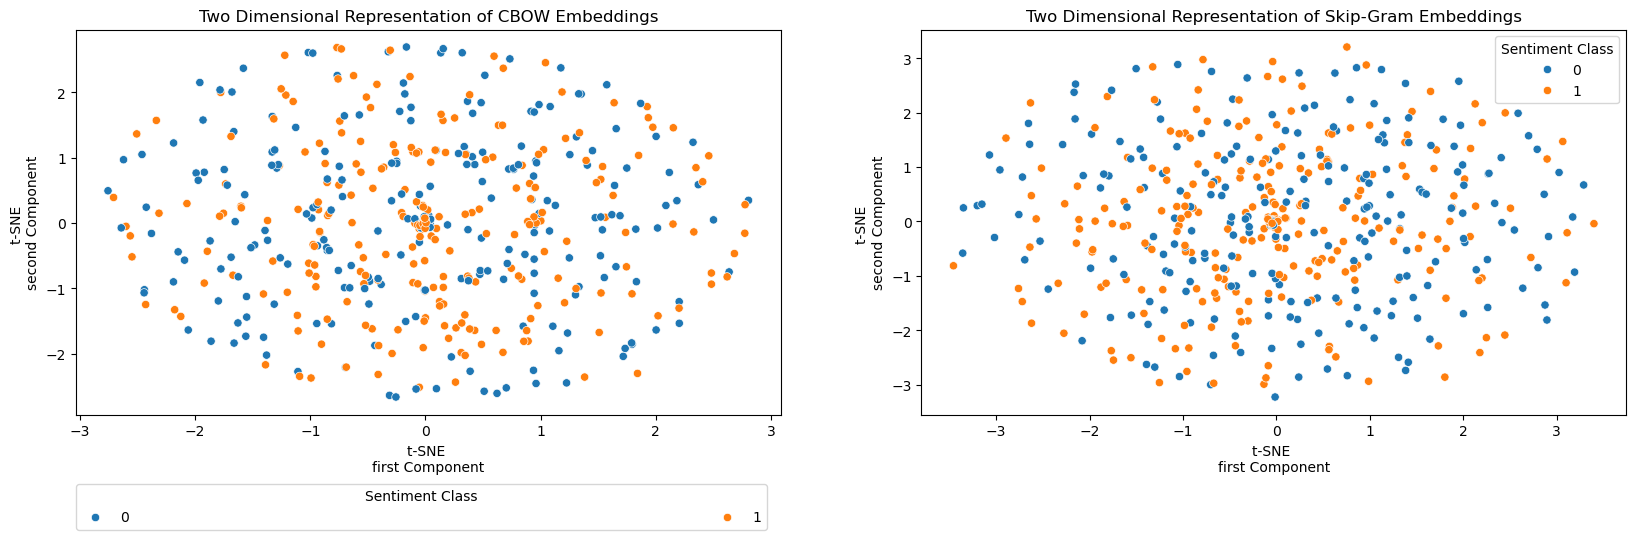

In [160]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(20,5))
sns.scatterplot(x='X-Axis',y='Y-Axis',data=cbow_tsne_embeddings,hue='Sentiment Class',ax=ax[0])
ax[0].set_xlabel('t-SNE \nfirst Component')
ax[0].set_ylabel('t-SNE \nsecond Component')
ax[0].legend(mode='expand',ncols=2,loc=[0.0,-0.3],title='Sentiment Class')
ax[0].set_title('Two Dimensional Representation of CBOW Embeddings')

sns.scatterplot(x='X-Axis',y='Y-Axis',data=skipgram_tsne_embeddings,hue='Sentiment Class',ax=ax[1])
ax[1].set_xlabel('t-SNE \nfirst Component')
ax[1].set_ylabel('t-SNE \nsecond Component')
ax[1].set_title('Two Dimensional Representation of Skip-Gram Embeddings')

plt.show()
plt.close()


**Interpretation**:<br>
The scatter plots show that the W2V embeddings trained in a language modeling fashion do not distinguish between the two sentiment classes. If you import the pretrained embeddings from gensim, you would observe the same dependency. The reason could be related to the fact that the embeddings are originally not trained for sentiment classification purposes. By contrast, if you download a model, which has already been pretrained specifically for sentiment analysis, then most probably you would observe a different pattern. Thus, when selecting which pretrained embeddings to work with from a set of several options, generating scatter plots of the 2D t-SNE embeddings can guide your choice based on the visualized relationship to the sentiment classes. Concerning the last task in this notebook, the above scatter plots indicate that the MLP networks using the CBOW and Skip-Gram embeddings are likely to perform better when setting the embedding layers to trainable in comparison to freezing the embedding weights. 

## **3. MLP-based Neural Network with W2V Embeddings for Sentiment Classification** (Exercise 2)<br>
In this exercise, you are tasked with the implementation of two MLP-based neural networks for sentiment classification on the IMDB dataset using the W2V embeddings that we generated with CBOW and Skip-Gram in the demo part of this notebook:<br>
- build two sequential keras models (cbow_mlp_model and skipgram_mlp_model), which consists of six layers: <br>
an input layer with shape = (1), the `vectorize_layer` from the demo, the corresponding embedding layer from the demo (`embedding_layer_cbow` and `embedding_layer_skipgram`), GlobalAveragePooling1D layer, a GELU-based hidden layer with 10 units and a final Sigmoid-based prediction layer.<br>

- after compiling the models with the Adam optimizer and the binary crossentropy loss, overwrite the weights in the embedding layers with the embedding matrices from the demo `embeddings_cbow` and `embeddings_skipgram` by using the function `set_weights()`.
- make two runs with each model for 10 epochs with a batch size of 32: in the first run freeze the W2V weights, in the second run set the weights in the embedding layers to trainable. You should use the cleaned version of the train and test datasets from the demo when fitting the models, i.e, `Xclean_train` and `Xclean_test`.

- report the results in terms of AUC score, precision and recall score in a tabular overview. You can use the threshold of 0.5, so that you convert the keras probabilities into binary classes for the computation of the precision and recall scores.  

In [132]:
predictions_results_frame=[]

for nr_run in [0,1]:

  cbow_mlp_model = Sequential([
    keras.layers.Input(shape=(1), dtype='string'),
    vectorize_layer,
    keras.layers.Embedding(vocab_size,embeddings_dimension,input_length=100,trainable=(False if nr_run==0 else True)),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(10, activation='gelu',kernel_initializer='he_normal'),
    keras.layers.Dense(1,activation='sigmoid') ])

  skipgram_mlp_model = Sequential([
    keras.layers.Input(shape=(1), dtype='string'),
    vectorize_layer,
    keras.layers.Embedding(vocab_size,embeddings_dimension,input_length=100,trainable=(False if nr_run==0 else True)),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(10, activation='gelu',kernel_initializer='he_normal'),
    keras.layers.Dense(1,activation='sigmoid') ])

  cbow_mlp_model.compile(loss='binary_crossentropy',optimizer='adam')
  cbow_mlp_model.layers[1].set_weights(np.array([embeddings_cbow]))
  
  skipgram_mlp_model.compile(loss='binary_crossentropy',optimizer='adam')
  skipgram_mlp_model.layers[1].set_weights(np.array([embeddings_skipgram]))

  cbow_mlp_model.fit(Xclean_train.to_numpy().reshape(-1,1), 
                     y_train,
                     epochs=10,batch_size=32,verbose=0)
  cbow_proba_pr=cbow_mlp_model.predict(Xclean_test.to_numpy().reshape(-1,1),verbose=0).flatten()
  cbow_class_pr=np.where(cbow_proba_pr>=0.5,1.0,0.0)
  predictions_results_frame.append([recall_score(y_true=y_test,y_pred=cbow_class_pr),
                                precision_score(y_true=y_test,y_pred=cbow_class_pr),
                                roc_auc_score(y_true=y_test,y_score=cbow_proba_pr)])

  
  skipgram_mlp_model.fit(Xclean_train.to_numpy().reshape(-1,1), 
                         y_train,
                         epochs=10,batch_size=32,verbose=0)
  skipgram_proba_pr=skipgram_mlp_model.predict(Xclean_test.to_numpy().reshape(-1,1),verbose=0).flatten()
  skipgram_class_pr=np.where(skipgram_proba_pr>=0.5,1.0,0.0)
  predictions_results_frame.append([recall_score(y_true=y_test,y_pred=skipgram_class_pr),
                                precision_score(y_true=y_test,y_pred=skipgram_class_pr),
                                roc_auc_score(y_true=y_test,y_score=skipgram_proba_pr)])

results_overview=pd.DataFrame(np.around(np.array(predictions_results_frame),3),columns=['Recall Score','Precision Score','ROC Auc Score'],
            index=['MLP-CBOW (non-trainable)','MLP-SkipGram (non-trainable)',
                   'MLP-CBOW (trainable)','MLP-SkipGram (trainable)'])

In [ ]:
results_overview.sort_index()

,Recall Score,Precision Score,ROC Auc Score
MLP-CBOW (non-trainable),0.810,0.772,0.877
MLP-CBOW (trainable),0.845,0.810,0.912
MLP-SkipGram (non-trainable),0.783,0.769,0.867
MLP-SkipGram (trainable),0.834,0.826,0.916


## **Bonus: Plotting trained CBOW and Skip-Gram embeddings** (not part of the student notebook)<br>
In this section, we will plot the latent representation produced by the trained MLP models in two ways. First, we will plot the embeddings from the trained embedding layers, and afterward, we will plot the latent features produced by the GELU-based MLP layers of the CBOW and Skip-Gram neural networks. To avoid redundant code, we will put the code for plotting of embeddings, which we have previously used, in the function below:

In [157]:
def plot_embeddings(num_samples:int,
                    Xclean_train:pd.DataFrame,
                    vectorize_layer:keras.layers.TextVectorization,
                    plot_w2v_embeddings:bool,
                    plot_w2v_mlp=None,
                    embedding_layer_cbow=None,
                    embedding_layer_skipgram=None, 
                    cbow_mlp_model=None, 
                    skipgram_mlp_model=None):
    
    
    '''
    Plots a two-dimensional embeddings representation of text embeddings.

    Parameters:
    -----------
    num_samples: int
        The number of textual samples, the embeddings of which to consider for plotting.

    Xclean_train: pd.DataFrame
        The dataframe containing the train data samples.

    vectorize_layer: keras.layers.TextVectorization
        The text vectorization layer, which has been adapted on Xclean_train already.

    plot_w2v_embeddings: bool
        Whether to plot the embeddings produced by W2V from the language modeling task.

    plot_w2v_mlp: None 
        Whether to plot the embeddings produced by the trained MLPs using the embedding layers with  weights from W2V.
        This parameter is None if plot_w2v_embeddings==True. Negative values of this parameter indicate plotting the latent 
        features produced by the nonlinear MLP layers, and not the embedding layers in the MLP-based networks.

    embedding_layer_cbow & embedding_layer_skipgram: None 
        The embedding layers, containing the weights from W2V (stil not trained on the task of sentiment classification).
        These parameters take values different from None, when plot_w2v_embeddings==True.

    cbow_mlp_model & skipgram_mlp_model: None
        The trained MLP-based models using W2V embedding layers. These parameters take values different from None, when 
        plot_w2v_embeddings==False, and plot_w2v_mlp is different from None.


    Returns:
    --------
    None

    '''
    

    if plot_w2v_embeddings==True:
        cbow_reviews_train=embedding_layer_cbow(vectorize_layer(Xclean_train.iloc[:num_samples])).numpy()
        cbow_reviews_train=cbow_reviews_train.reshape(cbow_reviews_train.shape[0],cbow_reviews_train.shape[1]*cbow_reviews_train.shape[2])

        skipgram_reviews_train=embedding_layer_skipgram(vectorize_layer(Xclean_train.iloc[:num_samples])).numpy()
        skipgram_reviews_train=skipgram_reviews_train.reshape(skipgram_reviews_train.shape[0],skipgram_reviews_train.shape[1]*skipgram_reviews_train.shape[2])
    else:
        if plot_w2v_mlp==True:
            cbow_reviews_train=cbow_mlp_model.layers[1](cbow_mlp_model.layers[0](Xclean_train.iloc[:num_samples])).numpy()
            cbow_reviews_train=cbow_reviews_train.reshape(cbow_reviews_train.shape[0],cbow_reviews_train.shape[1]*cbow_reviews_train.shape[2])

            skipgram_reviews_train=skipgram_mlp_model.layers[1](skipgram_mlp_model.layers[0](Xclean_train.iloc[:num_samples])).numpy()
            skipgram_reviews_train=skipgram_reviews_train.reshape(skipgram_reviews_train.shape[0],skipgram_reviews_train.shape[1]*skipgram_reviews_train.shape[2])
        else:
            cbow_reviews_train=cbow_mlp_model.layers[3](cbow_mlp_model.layers[2](cbow_mlp_model.layers[1](cbow_mlp_model.layers[0](Xclean_train.iloc[:num_samples])))).numpy()
            skipgram_reviews_train=skipgram_mlp_model.layers[3](skipgram_mlp_model.layers[2](skipgram_mlp_model.layers[1](skipgram_mlp_model.layers[0](Xclean_train.iloc[:num_samples])))).numpy()
            #Since the nonlinear dense layers produce two-dimensional latent feature space, there is no need to flatten the outputs.



    cbow_tsne_embeddings = TSNE().fit(cbow_reviews_train)
    cbow_tsne_embeddings=pd.DataFrame({'X-Axis':cbow_tsne_embeddings[:,0],
                                    'Y-Axis':cbow_tsne_embeddings[:,1],
                                    'Sentiment Class':y_train[:num_samples]})

    skipgram_tsne_embeddings = TSNE().fit(skipgram_reviews_train)
    skipgram_tsne_embeddings=pd.DataFrame({'X-Axis':skipgram_tsne_embeddings[:,0],
                                        'Y-Axis':skipgram_tsne_embeddings[:,1],
                                            'Sentiment Class':y_train[:num_samples]})

    fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(20,5))
    sns.scatterplot(x='X-Axis',y='Y-Axis',data=cbow_tsne_embeddings,hue='Sentiment Class',ax=ax[0])
    ax[0].set_xlabel('t-SNE \nfirst Component')
    ax[0].set_ylabel('t-SNE \nsecond Component')
    ax[0].legend(mode='expand',ncols=2,loc=[0.0,-0.3],title='Sentiment Class')
    if plot_w2v_mlp==True:
        ax[0].set_title('Two Dimensional Representation of CBOW Embeddings')
    else:
        ax[0].set_title('Two Dimensional Representation of GELU-based MLP latent Features \n(CBOW Embeddings)')


    sns.scatterplot(x='X-Axis',y='Y-Axis',data=skipgram_tsne_embeddings,hue='Sentiment Class',ax=ax[1])
    ax[1].set_xlabel('t-SNE \nfirst Component')
    ax[1].set_ylabel('t-SNE \nsecond Component')
    if plot_w2v_mlp==True:
        ax[1].set_title('Two Dimensional Representation of Skip-Gram Embeddings')
    else:
        ax[1].set_title('Two Dimensional Representation of GELU-based MLP latent Features \n(Skip-Gram Embeddings)')
    
    legend=ax[1].legend()
    legend.remove()

    plt.show()
    plt.close()

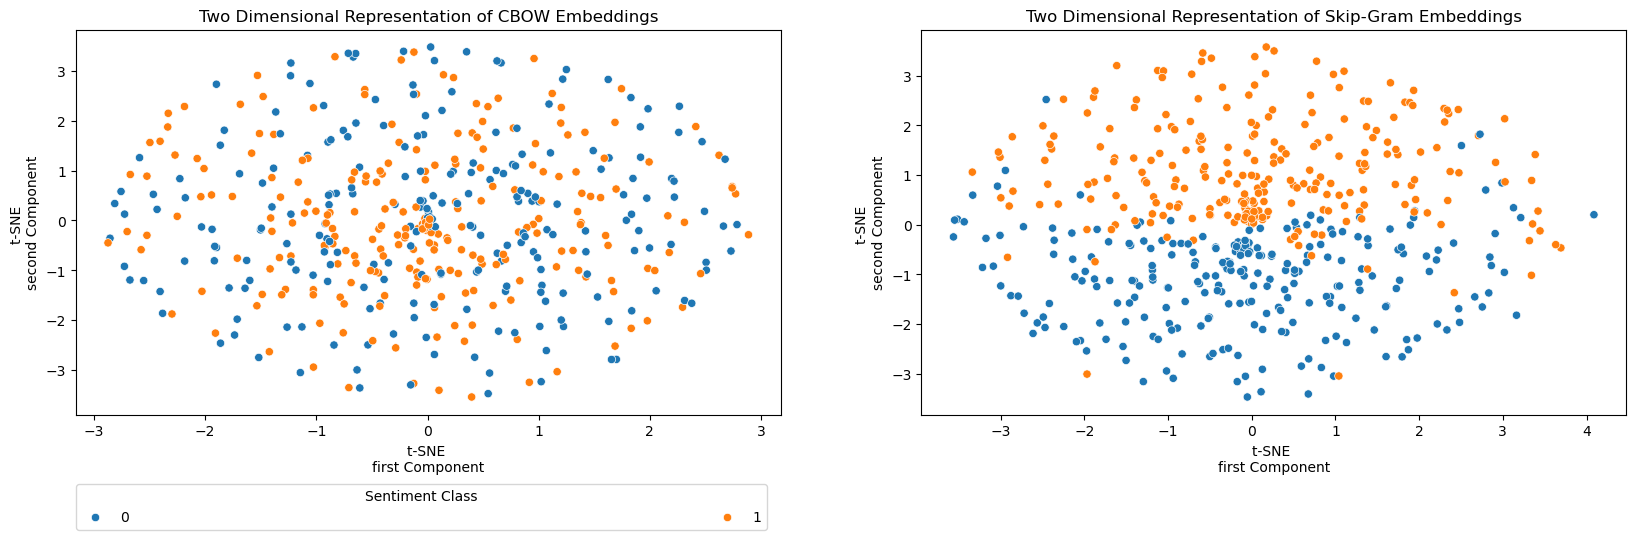

In [161]:
plot_embeddings(num_samples=500,Xclean_train=Xclean_train,vectorize_layer=vectorize_layer,
                plot_w2v_embeddings=False,plot_w2v_mlp=True,
                cbow_mlp_model=cbow_mlp_model,skipgram_mlp_model=skipgram_mlp_model)

The scatter plots of the trained embedding layers clearly show that the two-dimensional representation of the Skip-Gram embeddings clusters better the train samples w.r.t. the sentiment classes than the CBOW embeddings. This is highly likely related to the quality of the embeddings that the two W2V methods produce. CBOW is more efficient, as it performs a single pass per center word with the inputs being the average embedding coming from all context tokens. By contrast, Skip-Gram is less efficient, and yet likely produces higher quality embeddings w.r.t. the contextual information captured by the weights, as Skip-Gram performs one forward pass for every context word of a given center word. Nonetheless, both neural networks using CBOW and Skip-Gram embeddings produce an AUC score above 90%. This implies, that the GELU-based hidden layer of these networks manages to find certain patterns in both cases, that allow for the overall accurate seperatation between the two classes. To verify this conclusion, below we plot the latent features produced by the GELU-MLP layers of the two networks: 

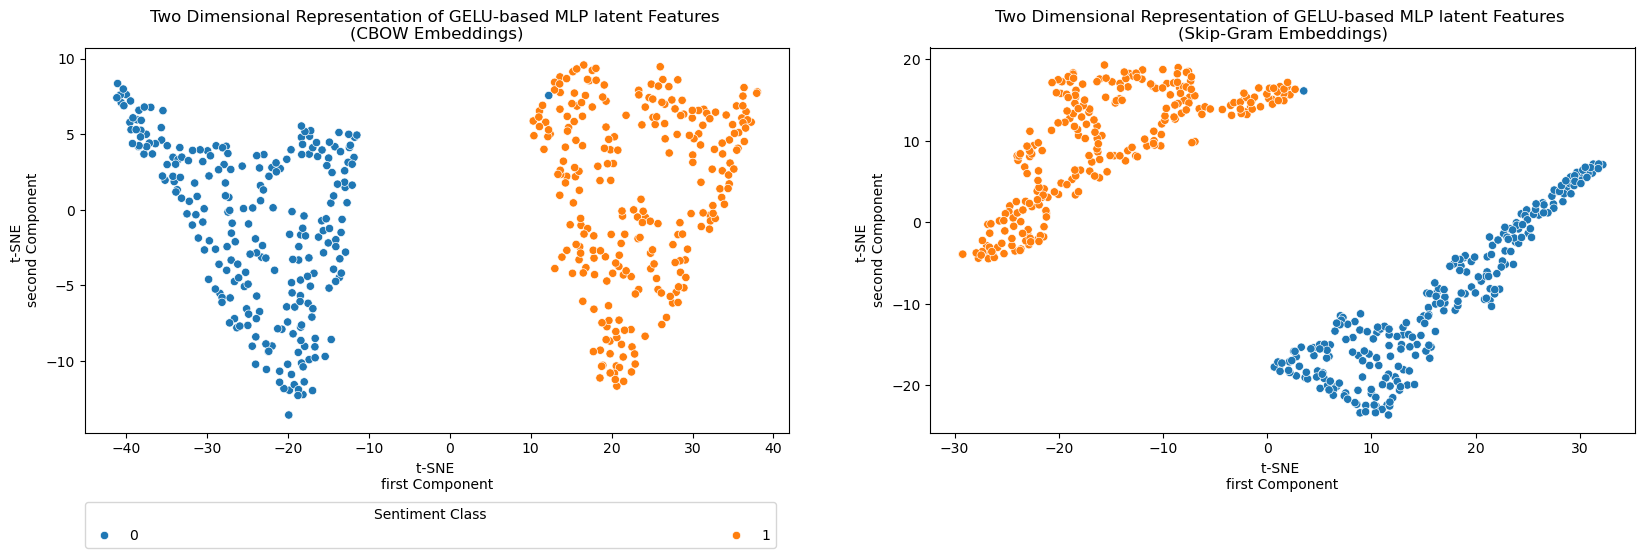

In [162]:
plot_embeddings(num_samples=500,Xclean_train=Xclean_train,vectorize_layer=vectorize_layer,
                plot_w2v_embeddings=False,plot_w2v_mlp=False,
                cbow_mlp_model=cbow_mlp_model,skipgram_mlp_model=skipgram_mlp_model)